In [20]:
import pandas as pd
import numpy as np
import warnings
import plotnine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor
import datetime
from sklearn.svm import SVR

In [21]:
data_path='train.csv'
data_path1='test.csv'

In [93]:

class BikeDataAnalyzer:
    def __init__(self, data_path=None):
        self.data = None
        self.cleaned_data = None
        self.scaler = StandardScaler()
        if data_path:
            self.load_data(data_path)
    
    def load_data(self, data_path):
        """加载数据"""
        try:
            self.data = pd.read_csv(data_path)
            print(f"数据加载成功，形状: {self.data.shape}")
        except FileNotFoundError:
            print("文件未找到")
    def basic_info(self):
        """显示数据基本信息"""
        print("=" * 50)
        print("数据基本信息")
        print("=" * 50)
        print(f"数据形状: {self.data.shape}")
        print(f"\n数据类型:")
        print(self.data.dtypes)
        print(f"\n前5行数据:")
        print(self.data.head())
        print(f"\n缺失值统计:")
        print(self.data.isnull().sum())
        print(f"\n数值列统计信息:")
        print(self.data.describe())
    def clean_data(self):
        """数据清洗"""
        print("\n开始数据清洗...")

        # 复制原始数据
        self.cleaned_data = self.data.copy()

        # 转换datetime列为时间类型
        self.cleaned_data['datetime'] = pd.to_datetime(self.cleaned_data['datetime'])

        # 提取时间特征
        self.cleaned_data['year'] = self.cleaned_data['datetime'].dt.year
        self.cleaned_data['month'] = self.cleaned_data['datetime'].dt.month
        self.cleaned_data['hour'] = self.cleaned_data['datetime'].dt.hour
        self.cleaned_data['day_of_week'] = self.cleaned_data['datetime'].dt.dayofweek
        self.cleaned_data['day_of_month'] = self.cleaned_data['datetime'].dt.day  
        self.cleaned_data["season"] = self.cleaned_data["season"].map({
            1: "Spring", 
            2: "Summer", 
            3: "Fall", 
            4: "Winter"
        })

 

        print("数据清洗完成")
        print(f"清洗后数据形状: {self.cleaned_data.shape}")
        print(self.cleaned_data.head())
        return self.cleaned_data 

In [94]:
analyzer = BikeDataAnalyzer(data_path)
        

analyzer.basic_info()
        
dfc=analyzer.clean_data()


数据加载成功，形状: (10886, 12)
数据基本信息
数据形状: (10886, 12)

数据类型:
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

前5行数据:
        datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011/1/1 0:00       1        0           0        1  9.84  14.395   
1  2011/1/1 1:00       1        0           0        1  9.02  13.635   
2  2011/1/1 2:00       1        0           0        1  9.02  13.635   
3  2011/1/1 3:00       1        0           0        1  9.84  14.395   
4  2011/1/1 4:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75       

   holiday  casual_ratio
0        0      0.169618
1        1      0.218286    workingday  casual_ratio
0           0      0.245785
1           1      0.135961


Text(0.5, 1.0, 'Average Casual Users Ratio\nby Working Day Status')

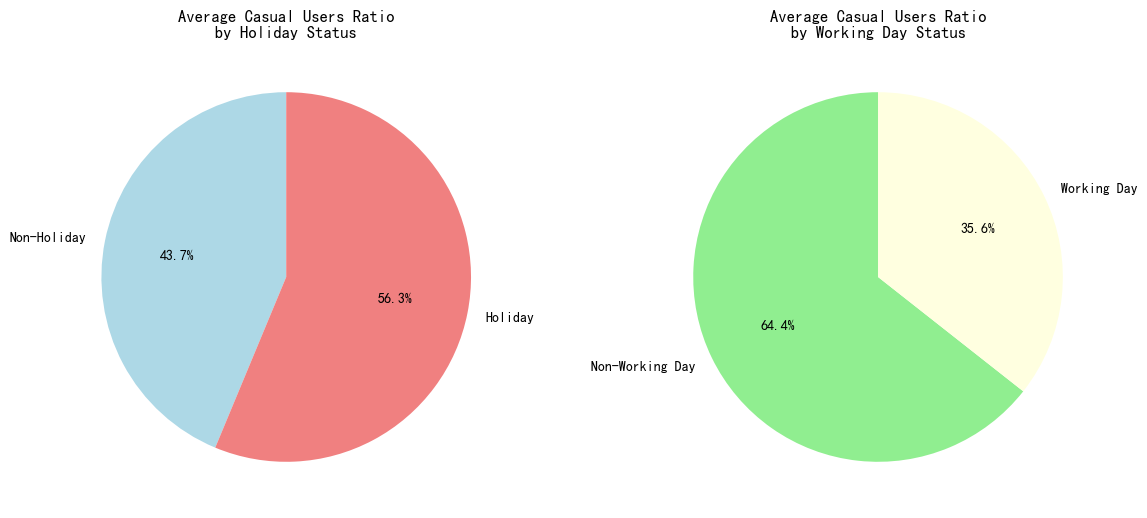

In [95]:



dfc['casual_ratio'] = dfc['casual'] / dfc['count']

holiday_stats = dfc.groupby('holiday')['casual_ratio'].mean().reset_index()

workingday_stats = dfc.groupby('workingday')['casual_ratio'].mean().reset_index()
print(holiday_stats,workingday_stats)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sizes_holiday = [holiday_stats[holiday_stats['holiday'] == 0]['casual_ratio'].iloc[0], 
                 holiday_stats[holiday_stats['holiday'] == 1]['casual_ratio'].iloc[0]]
labels_holiday = ['Non-Holiday', 'Holiday']
colors_holiday = ['lightblue', 'lightcoral']
wedges1, texts1, autotexts1 = axes[0].pie(sizes_holiday, labels=labels_holiday, colors=colors_holiday, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Average Casual Users Ratio\nby Holiday Status')

sizes_workingday = [workingday_stats[workingday_stats['workingday'] == 0]['casual_ratio'].iloc[0], 
                    workingday_stats[workingday_stats['workingday'] == 1]['casual_ratio'].iloc[0]]
labels_workingday = ['Non-Working Day', 'Working Day']
colors_workingday = ['lightgreen', 'lightyellow']
wedges2, texts2, autotexts2 = axes[1].pie(sizes_workingday, labels=labels_workingday, colors=colors_workingday, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Average Casual Users Ratio\nby Working Day Status')

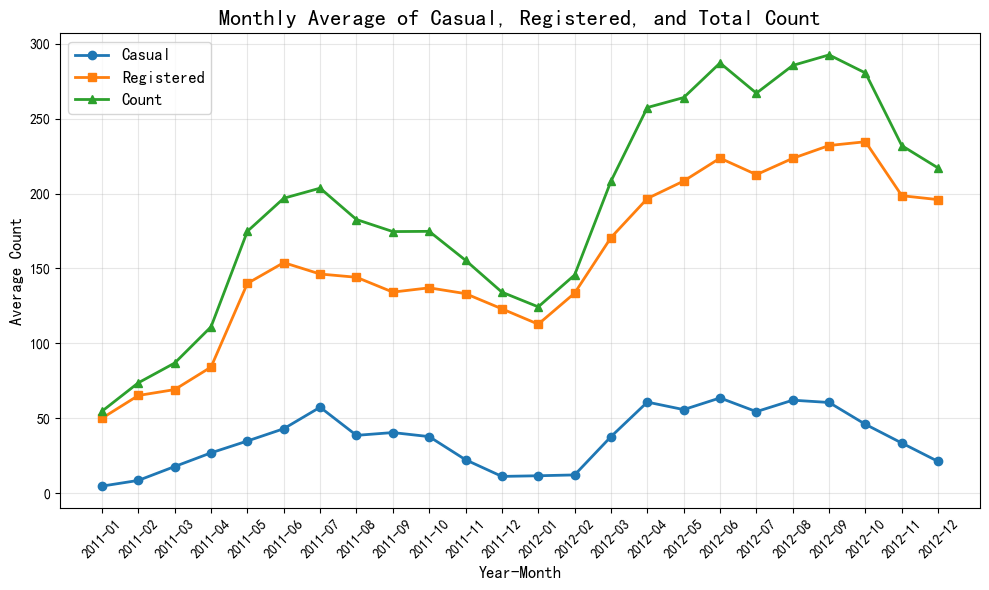

In [96]:
# 时间的折线图
df_monthly = dfc.groupby(['year', 'month']).agg({
    'casual': 'mean',
    'registered': 'mean',
    'count': 'mean'
}).reset_index()

df_monthly['year_month'] = df_monthly['year'].astype(str) + '-' + df_monthly['month'].astype(str).str.zfill(2)

plt.figure(figsize=(10, 6))

plt.plot(df_monthly['year_month'], df_monthly['casual'], label='Casual', marker='o', linewidth=2)
plt.plot(df_monthly['year_month'], df_monthly['registered'], label='Registered', marker='s', linewidth=2)
plt.plot(df_monthly['year_month'], df_monthly['count'], label='Count', marker='^', linewidth=2)

plt.title('Monthly Average of Casual, Registered, and Total Count', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Average Count', fontsize=12)

plt.xticks(rotation=45)

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

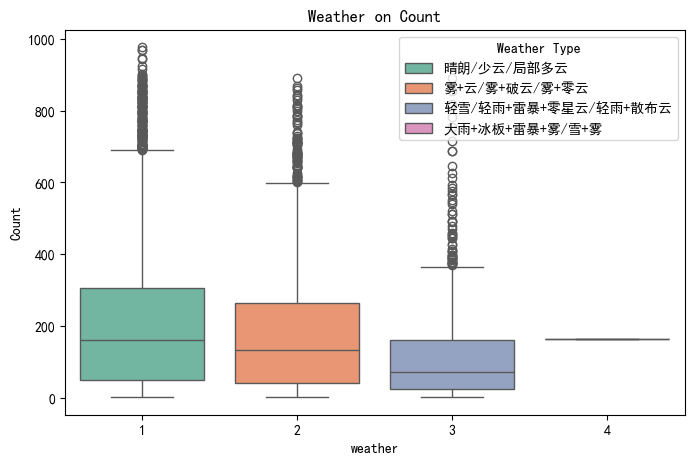

In [114]:
weather_labels = {
    1: '晴朗/少云/局部多云',
    2: '雾+云/雾+破云/雾+零云',
    3: '轻雪/轻雨+雷暴+零星云/轻雨+散布云',
    4: '大雨+冰板+雷暴+雾/雪+雾'
}
dfc['weather_label'] = dfc['weather'].map(weather_labels)

fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(8, 5)
sns.boxplot(data=dfc,y="count",x="weather",hue='weather',orient="v",palette="Set2")

axes.set(ylabel='Count',title="Weather on Count")
handles0, labels0 = axes.get_legend_handles_labels()
axes.legend(handles0, [weather_labels[int(label)] for label in labels0], title="Weather Type")




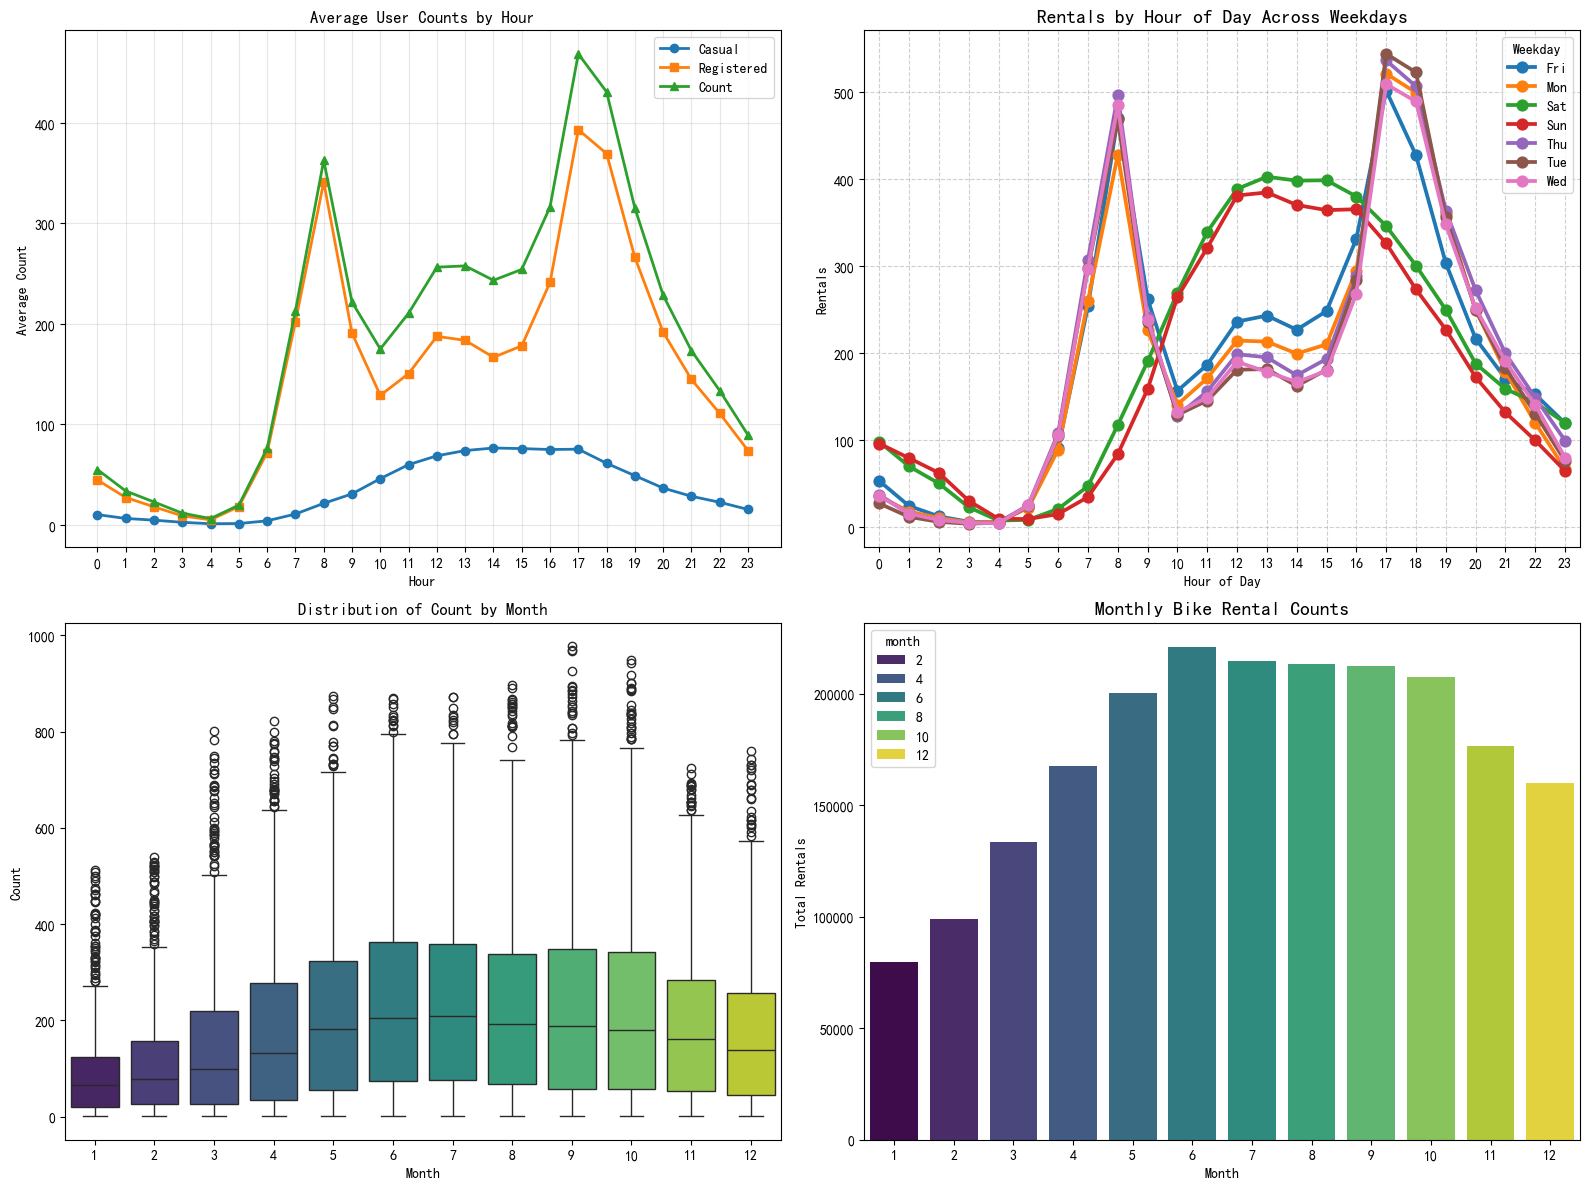

In [104]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

day_mapping = {
    0: 'Mon',  # Monday
    1: 'Tue',  # Tuesday
    2: 'Wed',  # Wednesday
    3: 'Thu',  # Thursday
    4: 'Fri',  # Friday
    5: 'Sat',  # Saturday
    6: 'Sun'   # Sunday
}

# 将dfc中的day_of_week列映射为英文缩写
dfc['day_of_week'] = dfc['day_of_week'].map(day_mapping)

# 第一张图：按小时变化的用户数量趋势折线图
hourly_stats = dfc.groupby('hour').agg({
    'casual': 'mean',
    'registered': 'mean',
    'count': 'mean'
}).reset_index()

axes[0, 0].plot(hourly_stats['hour'], hourly_stats['casual'], label='Casual', marker='o', linewidth=2)
axes[0, 0].plot(hourly_stats['hour'], hourly_stats['registered'], label='Registered', marker='s', linewidth=2)
axes[0, 0].plot(hourly_stats['hour'], hourly_stats['count'], label='Count', marker='^', linewidth=2)
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Average Count')
axes[0, 0].set_title('Average User Counts by Hour')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(0, 24))

hourAggregated = pd.DataFrame(dfc.groupby(["hour","day_of_week"],sort=True)["count"].mean()).reset_index()

sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"], hue=hourAggregated["day_of_week"], 
              data=hourAggregated, ax=axes[0,1], palette='tab10', join=True)
axes[0,1].set_title('Rentals by Hour of Day Across Weekdays', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Rentals')
axes[0,1].grid(True, linestyle='--', alpha=0.6)
axes[0,1].legend(title='Weekday')

sns.boxplot(data=dfc, x='month', y='count', ax=axes[1, 0], palette='viridis')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Distribution of Count by Month')


sns.barplot(data=monthly_counts, x='month', y='count', hue='month',ax=axes[1,1], palette='viridis')
axes[1,1].set_title('Monthly Bike Rental Counts', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Total Rentals')


plt.tight_layout()

plt.show()

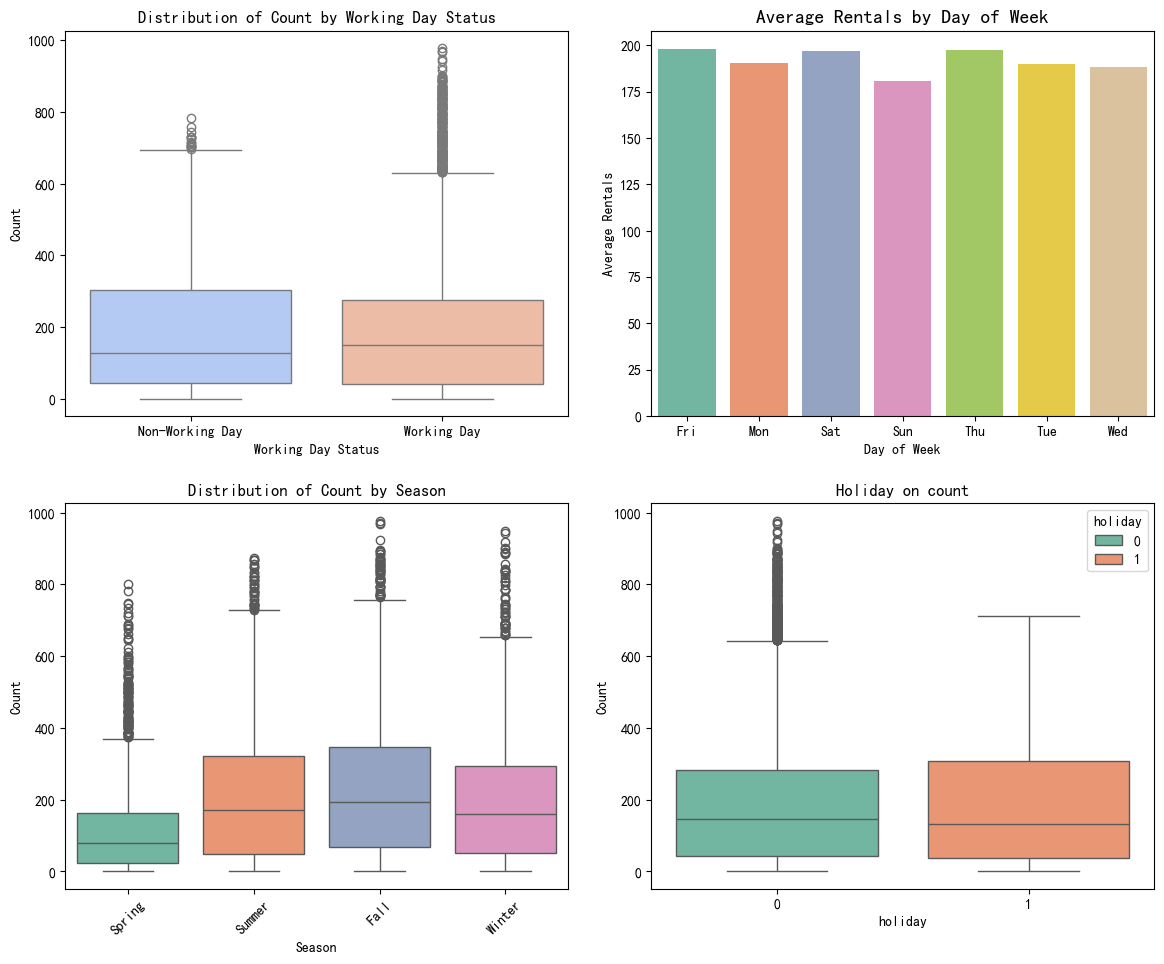

In [111]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
monthly_counts = dfc.groupby('month')['count'].sum().reset_index()

# 1.
sns.boxplot(data=dfc, x='workingday', y='count', ax=axes[0,0], palette='coolwarm')
axes[0,0].set_xlabel('Working Day Status')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Distribution of Count by Working Day Status')
axes[0,0].set_xticklabels(['Non-Working Day', 'Working Day'])

# 2. 每天（一周中）租车趋势
daily_counts = dfc.groupby('day_of_week')['count'].mean().reset_index()
sns.barplot(data=daily_counts,x='day_of_week', y='count',hue='day_of_week', ax=axes[0,1], palette='Set2')
axes[0,1].set_title('Average Rentals by Day of Week', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Average Rentals')


#3.
sns.boxplot(data=dfc, x='season', y='count', ax=axes[1,0], palette='Set2')
axes[1,0].set_xlabel('Season')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Distribution of Count by Season')
axes[1,0].tick_params(axis='x', rotation=45)


# 4.按季节分组


sns.boxplot(data=dfc,y="count",x="holiday",hue='holiday',orient="v",ax=axes[1,1],palette="Set2")
axes[1,1].set(xlabel='holiday', ylabel='Count',title="Holiday on count")

plt.tight_layout(pad=2.0)
plt.show()

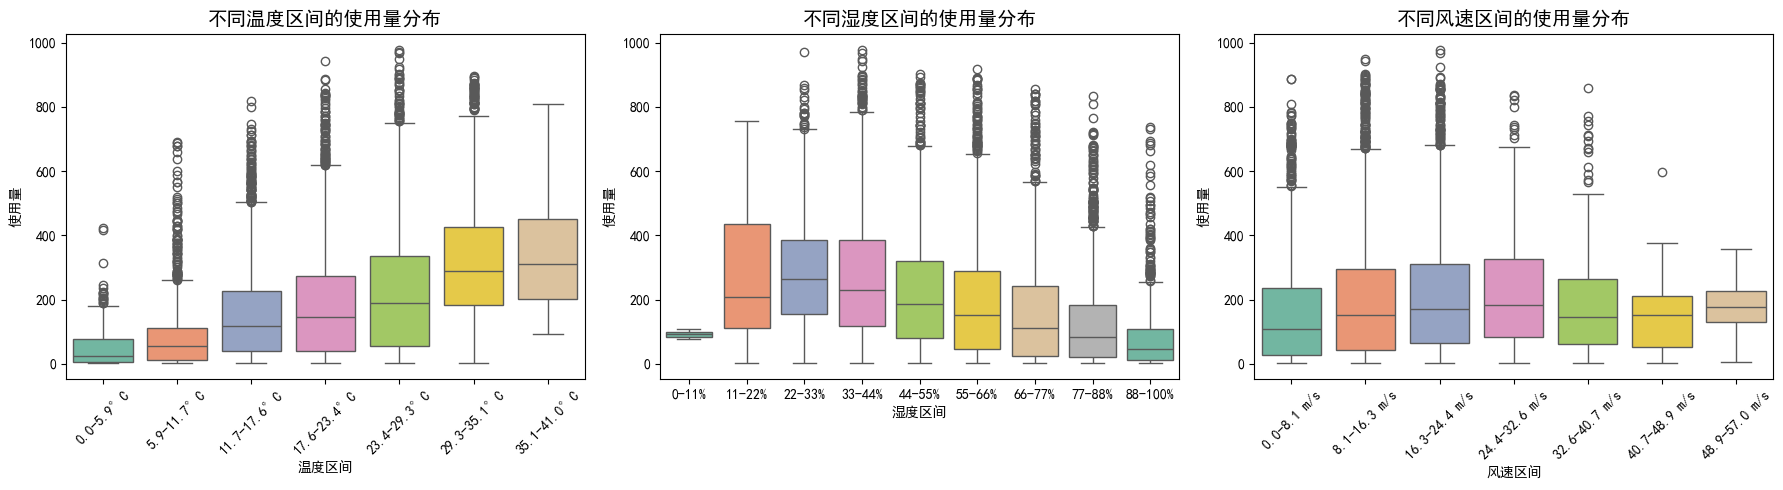

In [116]:
# 额外的组合图
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# 创建温度区间
temp_bins = np.linspace(0, 41, 8)  
dfc['temp_range'] = pd.cut(dfc['temp'], bins=temp_bins, 
                         labels=[f'{temp_bins[i]:.1f}-{temp_bins[i+1]:.1f}°C' 
                                for i in range(len(temp_bins)-1)])

# 创建湿度区间
hum_bins = np.linspace(0, 100, 10)  
dfc['hum_range'] = pd.cut(dfc['humidity'], bins=hum_bins, 
                        labels=[f'{int(hum_bins[i])}-{int(hum_bins[i+1])}%' 
                               for i in range(len(hum_bins)-1)])

# 创建风速区间
wind_bins = np.linspace(0, 57, 8)  # 分成5个区间
dfc['wind_range'] = pd.cut(dfc['windspeed'], bins=wind_bins, 
                         labels=[f'{wind_bins[i]:.1f}-{wind_bins[i+1]:.1f} m/s' 
                                for i in range(len(wind_bins)-1)])

sns.boxplot(data=dfc, x='temp_range', y='count', ax=axes[0],palette='Set2')
axes[0].set_title('不同温度区间的使用量分布', fontsize=14, fontweight='bold')
axes[0].set_xlabel('温度区间')
axes[0].set_ylabel('使用量')
axes[0].tick_params(axis='x', rotation=45)



sns.boxplot(data=dfc, x='hum_range', y='count', ax=axes[1], palette='Set2')
axes[1].set_title('不同湿度区间的使用量分布', fontsize=14, fontweight='bold')
axes[1].set_xlabel('湿度区间')
axes[1].set_ylabel('使用量')


sns.boxplot(data=dfc, x='wind_range', y='count', ax=axes[2], palette='Set2')
axes[2].set_title('不同风速区间的使用量分布', fontsize=14, fontweight='bold')
axes[2].set_xlabel('风速区间')
axes[2].set_ylabel('使用量')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [118]:
analyzer = BikeDataAnalyzer(data_path)
        

analyzer.basic_info()
        
dfc=analyzer.clean_data()


数据加载成功，形状: (10886, 12)
数据基本信息
数据形状: (10886, 12)

数据类型:
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

前5行数据:
        datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011/1/1 0:00       1        0           0        1  9.84  14.395   
1  2011/1/1 1:00       1        0           0        1  9.02  13.635   
2  2011/1/1 2:00       1        0           0        1  9.02  13.635   
3  2011/1/1 3:00       1        0           0        1  9.84  14.395   
4  2011/1/1 4:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75       

In [119]:
scaler = StandardScaler()
features = ['season_encoded', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 
            'year', 'month', 'hour', 'day_of_week', 'day_of_month']
le_season = LabelEncoder()
dfc['season_encoded'] = le_season.fit_transform(dfc['season'])

X = dfc[features]
y = dfc['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [120]:
X_train_scaled.shape
X_test_scaled.shape

(2178, 13)

In [125]:
# 模型评估函数
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # 训练模型
    model.fit(X_train, y_train)
    
    # 预测
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # 计算指标
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)
    train_rmse = np.sqrt(train_mse)    
    return {
        'Model': model_name,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MSE': train_mse,
        'Test_MSE': test_mse,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Test_MAE': test_mae
    }




In [128]:
# 1. 随机森林（调参）
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
rf_results = evaluate_model(rf_best, X_train, X_test, y_train, y_test, f"随机森林({rf_grid.best_params_})")



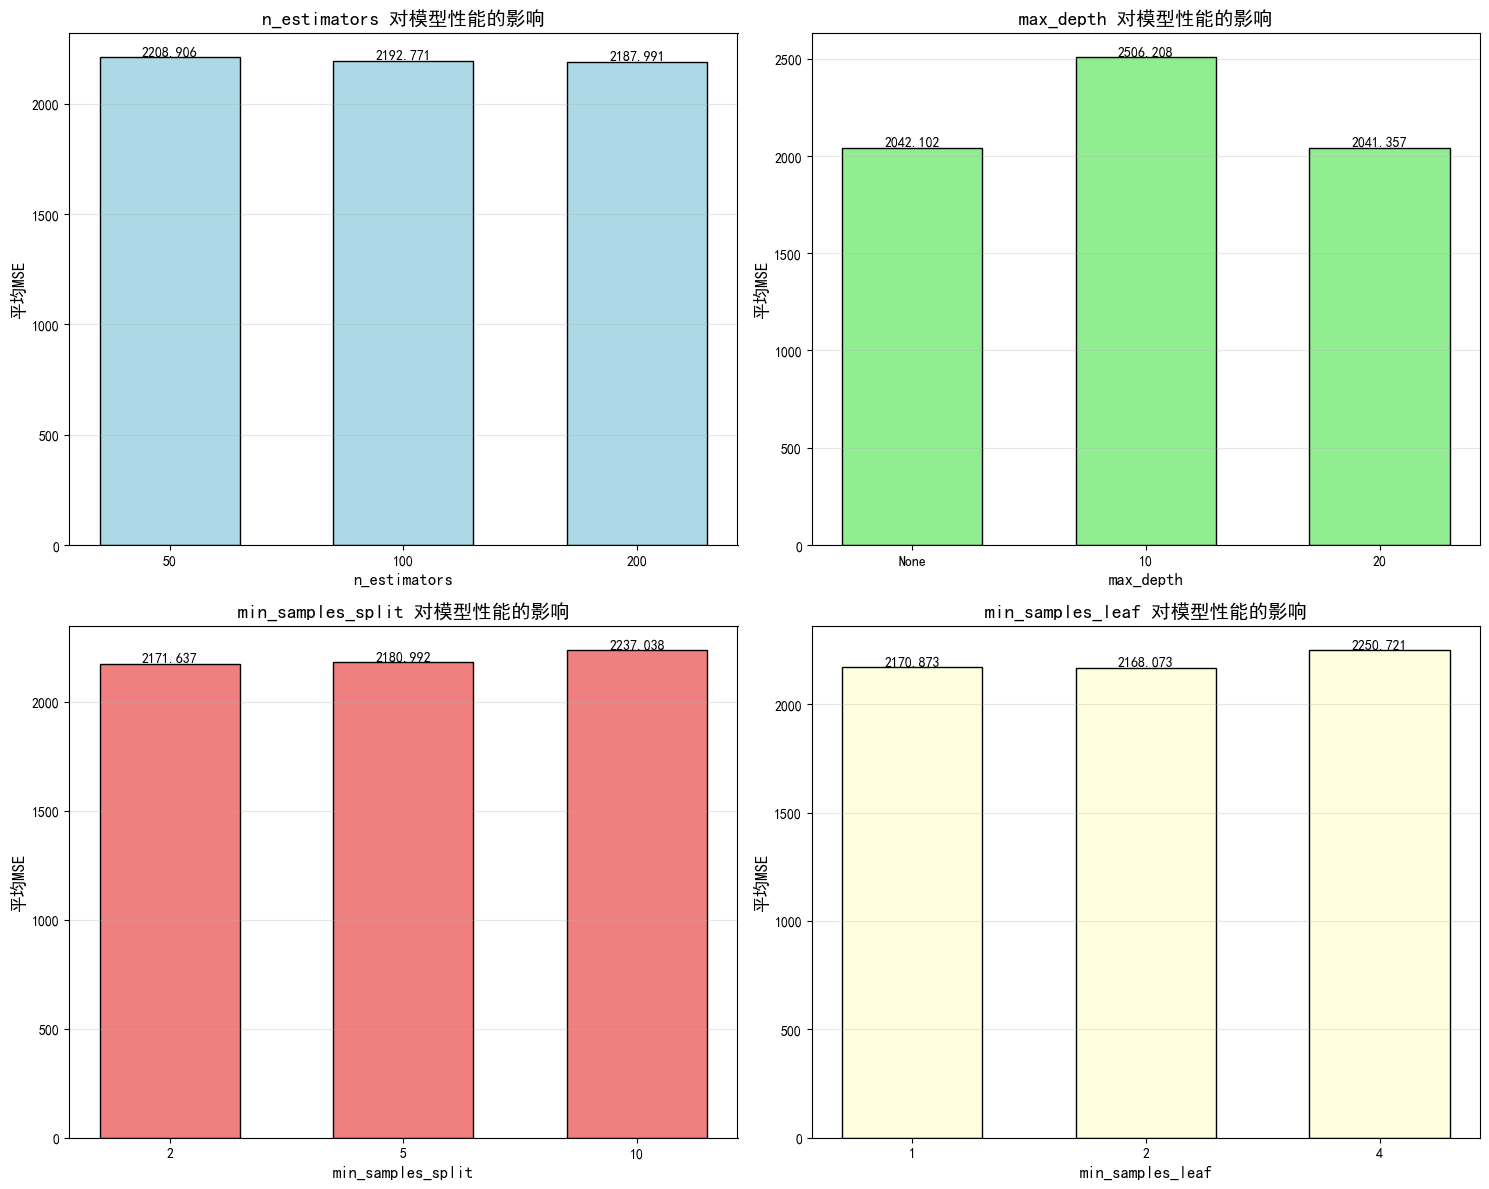

In [131]:
# 输出调参结果
print("随机森林调参结果:")
print(f"最佳参数: {rf_grid.best_params_}")
print(f"最佳交叉验证得分: {-rf_grid.best_score_:.4f}")

print("\n模型性能对比:")
results_df = pd.DataFrame([rf_results])
print(results_df.round(3))

# 分析不同参数组合的表现
cv_results = pd.DataFrame(rf_grid.cv_results_)
print(f"\n总共尝试了 {len(cv_results)} 种参数组合")

# 显示前10个最佳参数组合
print("\n前10个最佳参数组合:")
best_combinations = cv_results.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in best_combinations.iterrows():
    print(f"参数: {row['params']}, 得分: {-row['mean_test_score']:.4f} (+/- {row['std_test_score']*2:.4f})")


# 创建2x2的子图
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. n_estimators 对性能的影响
n_estimators_vals = [50, 100, 200]
n_est_scores = []
for n_est in n_estimators_vals:
    subset = cv_results[cv_results['param_n_estimators'] == n_est]
    n_est_scores.append(-subset['mean_test_score'].mean())

bar_positions = np.arange(len(n_estimators_vals))
bars1 = axes[0, 0].bar(bar_positions, n_est_scores, width=0.6, color='lightblue', edgecolor='black', linewidth=1)
axes[0, 0].set_xlabel('n_estimators', fontsize=12)
axes[0, 0].set_ylabel('平均MSE', fontsize=12)
axes[0, 0].set_title('n_estimators 对模型性能的影响', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(bar_positions)
axes[0, 0].set_xticklabels([str(val) for val in n_estimators_vals])

# 在柱子上添加数值标签
for bar, value in zip(bars1, n_est_scores):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. max_depth 对性能的影响
max_depth_vals = ['None', 10, 20]
max_depth_scores = []
for depth in [None, 10, 20]:
    if depth is None:
        subset = cv_results[cv_results['param_max_depth'].isna()]
    else:
        subset = cv_results[cv_results['param_max_depth'] == depth]
    max_depth_scores.append(-subset['mean_test_score'].mean())

bar_positions2 = np.arange(len(max_depth_vals))
bars2 = axes[0, 1].bar(bar_positions2, max_depth_scores, width=0.6, color='lightgreen', edgecolor='black', linewidth=1)
axes[0, 1].set_xlabel('max_depth', fontsize=12)
axes[0, 1].set_ylabel('平均MSE', fontsize=12)
axes[0, 1].set_title('max_depth 对模型性能的影响', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(bar_positions2)
axes[0, 1].set_xticklabels(max_depth_vals)

# 在柱子上添加数值标签
for bar, value in zip(bars2, max_depth_scores):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. min_samples_split 对性能的影响
min_samples_split_vals = [2, 5, 10]
split_scores = []
for split in min_samples_split_vals:
    subset = cv_results[cv_results['param_min_samples_split'] == split]
    split_scores.append(-subset['mean_test_score'].mean())

bar_positions3 = np.arange(len(min_samples_split_vals))
bars3 = axes[1, 0].bar(bar_positions3, split_scores, width=0.6, color='lightcoral', edgecolor='black', linewidth=1)
axes[1, 0].set_xlabel('min_samples_split', fontsize=12)
axes[1, 0].set_ylabel('平均MSE', fontsize=12)
axes[1, 0].set_title('min_samples_split 对模型性能的影响', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(bar_positions3)
axes[1, 0].set_xticklabels([str(val) for val in min_samples_split_vals])

# 在柱子上添加数值标签
for bar, value in zip(bars3, split_scores):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. min_samples_leaf 对性能的影响
min_samples_leaf_vals = [1, 2, 4]
leaf_scores = []
for leaf in min_samples_leaf_vals:
    subset = cv_results[cv_results['param_min_samples_leaf'] == leaf]
    leaf_scores.append(-subset['mean_test_score'].mean())

bar_positions4 = np.arange(len(min_samples_leaf_vals))
bars4 = axes[1, 1].bar(bar_positions4, leaf_scores, width=0.6, color='lightyellow', edgecolor='black', linewidth=1)
axes[1, 1].set_xlabel('min_samples_leaf', fontsize=12)
axes[1, 1].set_ylabel('平均MSE', fontsize=12)
axes[1, 1].set_title('min_samples_leaf 对模型性能的影响', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(bar_positions4)
axes[1, 1].set_xticklabels([str(val) for val in min_samples_leaf_vals])

# 在柱子上添加数值标签
for bar, value in zip(bars4, leaf_scores):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 添加网格
for ax in axes.flat:
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [123]:

# 2. SVM（调参）
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.2, 0.5]
}

svm_grid = GridSearchCV(
    SVR(kernel='rbf'),
    svm_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
svm_grid.fit(X_train_scaled, y_train)
svm_best = svm_grid.best_estimator_
svm_results = evaluate_model(svm_best, X_train_scaled, X_test_scaled, y_train, y_test, f"SVM({svm_grid.best_params_})")



SVM调参结果:
最佳参数: {'C': 100, 'epsilon': 0.5, 'gamma': 0.1}
最佳交叉验证得分: 14172.4591

模型性能对比:
                                           Model  Train_MSE   Test_MSE  \
0  SVM({'C': 100, 'epsilon': 0.5, 'gamma': 0.1})  12784.946  13502.534   

   Train_R2  Test_R2  Test_MAE  
0      0.61    0.591    69.993  

总共尝试了 96 种参数组合

前10个最佳参数组合:
参数: {'C': 100, 'epsilon': 0.5, 'gamma': 0.1}, 得分: 14172.4591 (+/- 700.3278)
参数: {'C': 100, 'epsilon': 0.2, 'gamma': 0.1}, 得分: 14175.4218 (+/- 700.8038)
参数: {'C': 100, 'epsilon': 0.1, 'gamma': 0.1}, 得分: 14176.3355 (+/- 700.7689)
参数: {'C': 100, 'epsilon': 0.01, 'gamma': 0.1}, 得分: 14176.9842 (+/- 701.0418)
参数: {'C': 100, 'epsilon': 0.5, 'gamma': 'scale'}, 得分: 14643.6669 (+/- 680.8397)
参数: {'C': 100, 'epsilon': 0.5, 'gamma': 'auto'}, 得分: 14643.7017 (+/- 686.2473)
参数: {'C': 100, 'epsilon': 0.1, 'gamma': 'auto'}, 得分: 14644.5624 (+/- 685.6601)
参数: {'C': 100, 'epsilon': 0.2, 'gamma': 'auto'}, 得分: 14644.6284 (+/- 685.3938)
参数: {'C': 100, 'epsilon': 0.2, 'gamma': 'scale'}

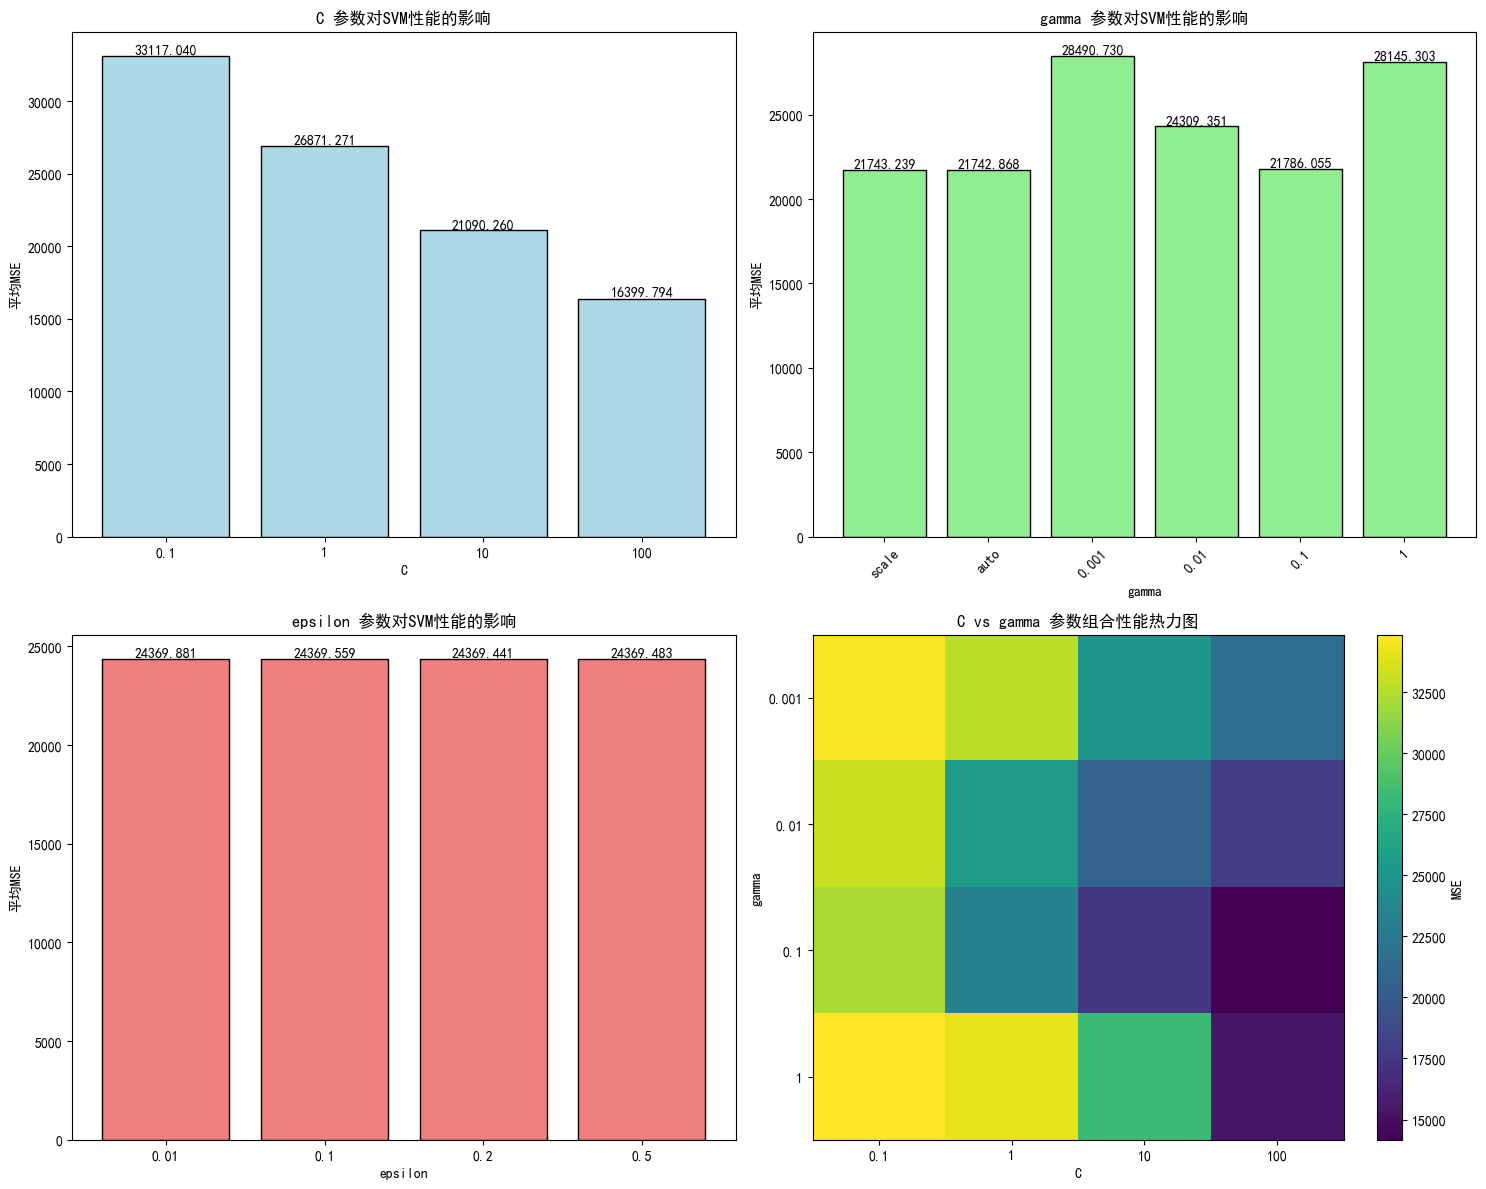


SVM调参结果分析:
1. 最佳 C: 100 - 控制正则化强度，C值越大模型对训练误差的容忍度越低
2. 最佳 gamma: 0.1 - 控制单个训练样本的影响范围，gamma越大影响范围越小
3. 最佳 epsilon: 0.5 - SVR中的epsilon-tube参数，定义了不惩罚的偏差范围

SVM最终模型在测试集上的表现:


KeyError: 'Test_RMSE'

In [127]:
# 输出调参结果
print("SVM调参结果:")
print(f"最佳参数: {svm_grid.best_params_}")
print(f"最佳交叉验证得分: {-svm_grid.best_score_:.4f}")

print("\n模型性能对比:")
results_df = pd.DataFrame([svm_results])
print(results_df.round(3))

# 分析不同参数组合的表现
cv_results = pd.DataFrame(svm_grid.cv_results_)
print(f"\n总共尝试了 {len(cv_results)} 种参数组合")

# 显示前10个最佳参数组合
print("\n前10个最佳参数组合:")
best_combinations = cv_results.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in best_combinations.iterrows():
    print(f"参数: {row['params']}, 得分: {-row['mean_test_score']:.4f} (+/- {row['std_test_score']*2:.4f})")

# 可视化调参结果
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. C 参数对性能的影响
c_values = [0.1, 1, 10, 100]
c_scores = []
for c in c_values:
    subset = cv_results[cv_results['param_C'] == c]
    c_scores.append(-subset['mean_test_score'].mean())

axes[0, 0].bar([str(c) for c in c_values], c_scores, color='lightblue', edgecolor='black')
axes[0, 0].set_xlabel('C')
axes[0, 0].set_ylabel('平均MSE')
axes[0, 0].set_title('C 参数对SVM性能的影响')
for i, v in enumerate(c_scores):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 2. gamma 参数对性能的影响
gamma_values = ['scale', 'auto', 0.001, 0.01, 0.1, 1]
gamma_scores = []
for gamma in gamma_values:
    if gamma in ['scale', 'auto']:
        subset = cv_results[cv_results['param_gamma'] == gamma]
    else:
        subset = cv_results[cv_results['param_gamma'] == gamma]
    if len(subset) > 0:
        gamma_scores.append(-subset['mean_test_score'].mean())
    else:
        gamma_scores.append(np.nan)

# 过滤掉NaN值
valid_gamma_values = [str(g) for g, s in zip(gamma_values, gamma_scores) if not np.isnan(s)]
valid_gamma_scores = [s for s in gamma_scores if not np.isnan(s)]

axes[0, 1].bar(valid_gamma_values, valid_gamma_scores, color='lightgreen', edgecolor='black')
axes[0, 1].set_xlabel('gamma')
axes[0, 1].set_ylabel('平均MSE')
axes[0, 1].set_title('gamma 参数对SVM性能的影响')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(valid_gamma_scores):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 3. epsilon 参数对性能的影响
epsilon_values = [0.01, 0.1, 0.2, 0.5]
epsilon_scores = []
for eps in epsilon_values:
    subset = cv_results[cv_results['param_epsilon'] == eps]
    epsilon_scores.append(-subset['mean_test_score'].mean())

axes[1, 0].bar([str(eps) for eps in epsilon_values], epsilon_scores, color='lightcoral', edgecolor='black')
axes[1, 0].set_xlabel('epsilon')
axes[1, 0].set_ylabel('平均MSE')
axes[1, 0].set_title('epsilon 参数对SVM性能的影响')
for i, v in enumerate(epsilon_scores):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 4. 参数组合热力图 - C vs gamma
# 创建C和gamma的交叉性能矩阵
c_vals = [0.1, 1, 10, 100]
gamma_vals = [0.001, 0.01, 0.1, 1]  # 只考虑数值型gamma

# 创建性能矩阵
performance_matrix = np.zeros((len(gamma_vals), len(c_vals)))
for i, gamma in enumerate(gamma_vals):
    for j, c in enumerate(c_vals):
        subset = cv_results[
            (cv_results['param_gamma'] == gamma) & 
            (cv_results['param_C'] == c)
        ]
        if len(subset) > 0:
            performance_matrix[i, j] = -subset['mean_test_score'].mean()
        else:
            performance_matrix[i, j] = np.nan

im = axes[1, 1].imshow(performance_matrix, cmap='viridis', aspect='auto')
axes[1, 1].set_xticks(range(len(c_vals)))
axes[1, 1].set_xticklabels([str(c) for c in c_vals])
axes[1, 1].set_yticks(range(len(gamma_vals)))
axes[1, 1].set_yticklabels([str(g) for g in gamma_vals])
axes[1, 1].set_xlabel('C')
axes[1, 1].set_ylabel('gamma')
axes[1, 1].set_title('C vs gamma 参数组合性能热力图')

# 添加颜色条
cbar = plt.colorbar(im, ax=axes[1, 1])
cbar.set_label('MSE')

plt.tight_layout()
plt.show()


# 调参结果分析
print("\nSVM调参结果分析:")
best_params = svm_grid.best_params_
print(f"1. 最佳 C: {best_params['C']} - 控制正则化强度，C值越大模型对训练误差的容忍度越低")
print(f"2. 最佳 gamma: {best_params['gamma']} - 控制单个训练样本的影响范围，gamma越大影响范围越小")
print(f"3. 最佳 epsilon: {best_params['epsilon']} - SVR中的epsilon-tube参数，定义了不惩罚的偏差范围")

print(f"\nSVM最终模型在测试集上的表现:")
print(f"RMSE: {svm_results['Test_RMSE']:.4f}")
print(f"MAE: {svm_results['Test_MAE']:.4f}")
print(f"R²: {svm_results['Test_R2']:.4f}")

print(f"\n调参建议:")
print(f"- C参数的选择需要平衡模型的复杂度和泛化能力")
print(f"- gamma参数影响模型的非线性程度，需要谨慎选择以避免过拟合")
print(f"- epsilon参数决定了模型对训练误差的容忍度，较小的值可能导致过拟合")

In [126]:
# 3. 神经网络（MLP，调参）
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

mlp_grid = GridSearchCV(
    MLPRegressor(max_iter=1000, random_state=42),
    mlp_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
mlp_grid.fit(X_train_scaled, y_train)
mlp_best = mlp_grid.best_estimator_
mlp_results = evaluate_model(mlp_best, X_train_scaled, X_test_scaled, y_train, y_test, f"神经网络({mlp_grid.best_params_})")



In [139]:
import xgboost as xgb

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_grid = GridSearchCV(
    xgb.XGBRegressor(random_state=42),
    xgb_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
xgb_results = evaluate_model(xgb_best, X_train, X_test, y_train, y_test, f"XGBoost({xgb_grid.best_params_})")



XGBoost调参结果:
最佳参数: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
最佳交叉验证得分: 1473.3521

XGBoost模型性能:
                                               Model  Train_RMSE  Test_RMSE  \
0  XGBoost({'colsample_bytree': 0.9, 'learning_ra...      17.209     33.824   

   Train_MSE  Test_MSE  Train_R2  Test_R2  Test_MAE  
0    296.148  1144.058     0.991    0.965    21.207  

总共尝试了 324 种参数组合

前10个最佳参数组合:
参数: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}, 得分: 1473.3521 (+/- 124.4646)
参数: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}, 得分: 1503.8047 (+/- 104.7531)
参数: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}, 得分: 1504.1079 (+/- 101.7332)
参数: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}, 得分: 1524.0705 (+/- 120.8165)

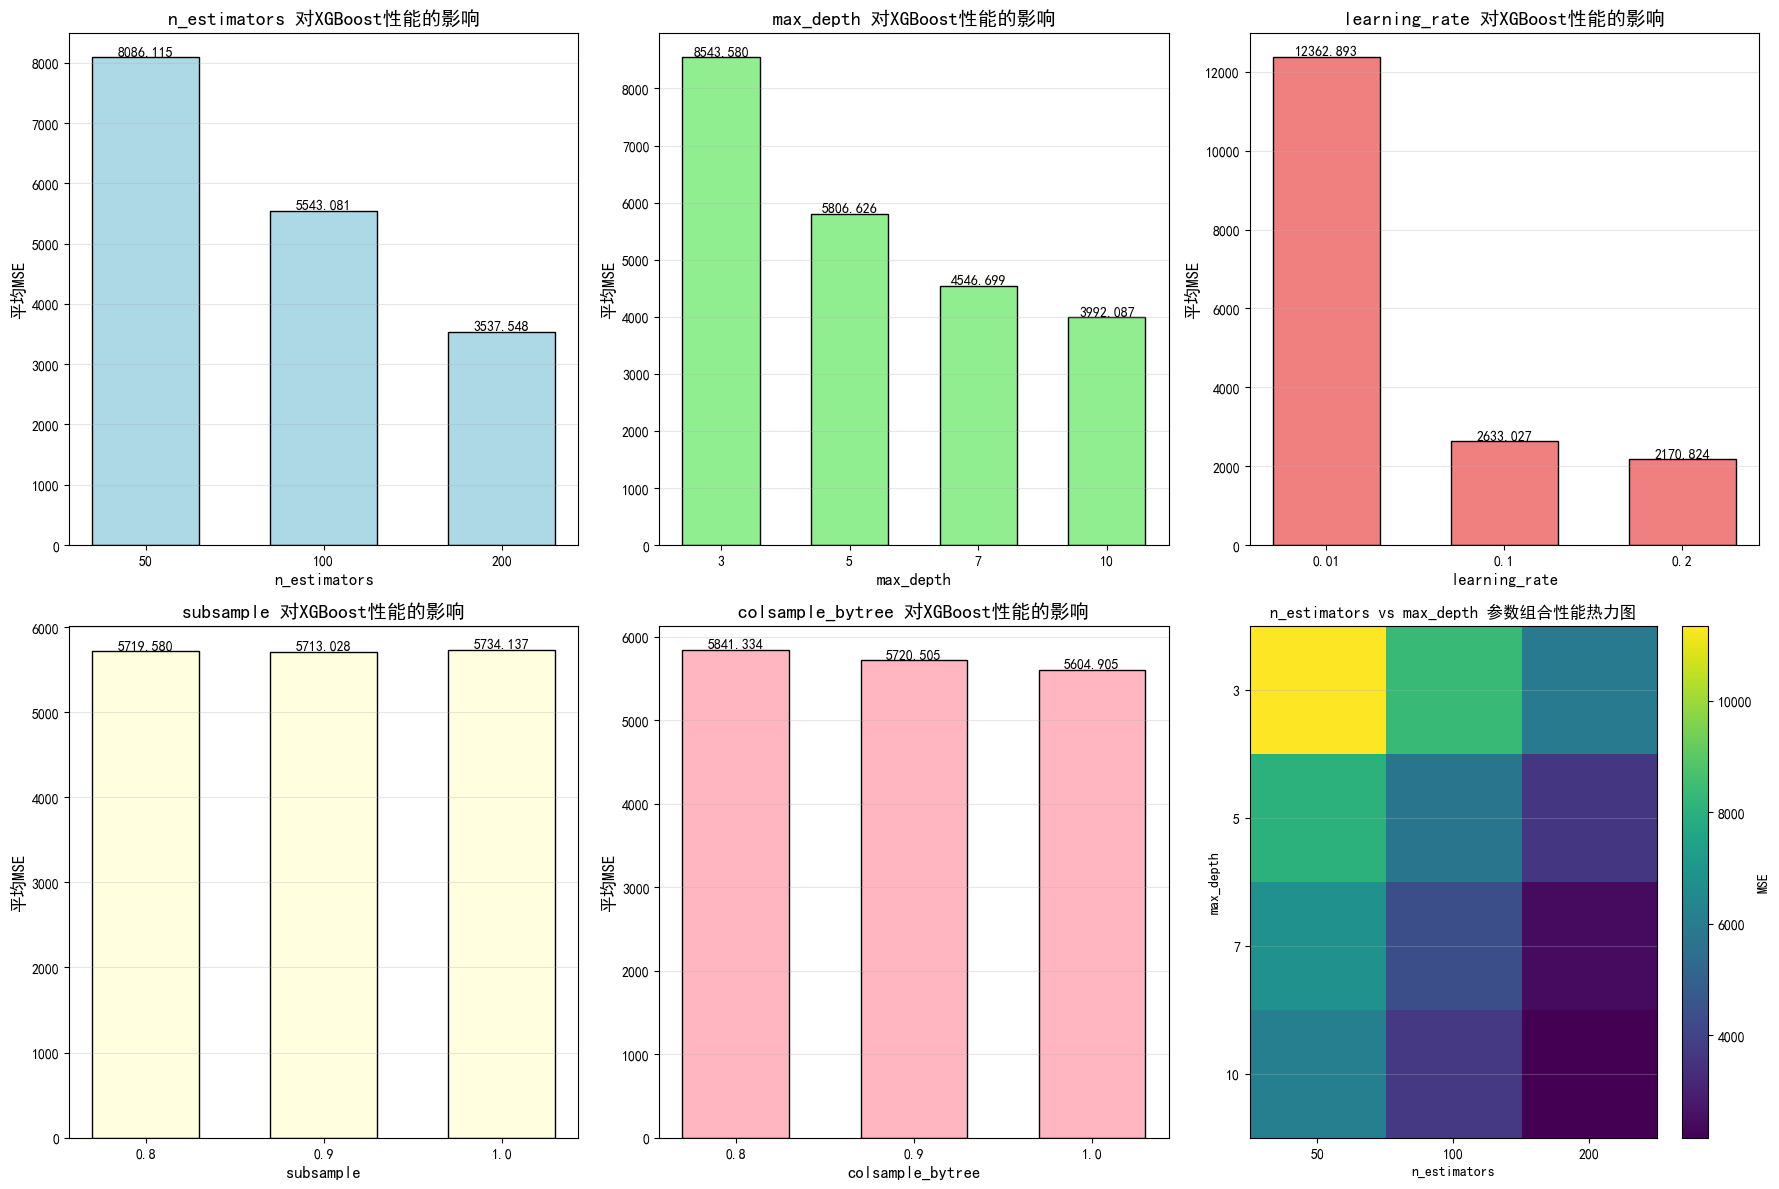


XGBoost调参结果分析:
1. 最佳 n_estimators: 200 - 控制树的数量，更多树可能提高性能但增加计算时间
2. 最佳 max_depth: 7 - 控制每棵树的最大深度，防止过拟合
3. 最佳 learning_rate: 0.1 - 学习率，控制每棵树的贡献，较小值需要更多树
4. 最佳 subsample: 0.8 - 每次构建树时使用的样本比例，防止过拟合
5. 最佳 colsample_bytree: 0.9 - 每次构建树时使用的特征比例，防止过拟合

XGBoost最终模型在测试集上的表现:
RMSE: 33.8239
MAE: 21.2072
R²: 0.9653

调参建议:
- n_estimators: 需要在性能和计算时间之间平衡
- max_depth: 控制模型复杂度，防止过拟合
- learning_rate: 与n_estimators配合使用，较小的学习率需要更多的树
- subsample和colsample_bytree: 用于正则化，防止过拟合


In [141]:
# 输出调参结果
print("XGBoost调参结果:")
print(f"最佳参数: {xgb_grid.best_params_}")
print(f"最佳交叉验证得分: {-xgb_grid.best_score_:.4f}")

print("\nXGBoost模型性能:")
results_df = pd.DataFrame([xgb_results])
print(results_df.round(3))

# 分析不同参数组合的表现
cv_results = pd.DataFrame(xgb_grid.cv_results_)
print(f"\n总共尝试了 {len(cv_results)} 种参数组合")

# 显示前10个最佳参数组合
print("\n前10个最佳参数组合:")
best_combinations = cv_results.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in best_combinations.iterrows():
    print(f"参数: {row['params']}, 得分: {-row['mean_test_score']:.4f} (+/- {row['std_test_score']*2:.4f})")

# 可视化调参结果
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. n_estimators 对性能的影响
n_est_vals = [50, 100, 200]
n_est_scores = []
for n_est in n_est_vals:
    subset = cv_results[cv_results['param_n_estimators'] == n_est]
    n_est_scores.append(-subset['mean_test_score'].mean())

bar_positions = np.arange(len(n_est_vals))
bars1 = axes[0, 0].bar(bar_positions, n_est_scores, width=0.6, color='lightblue', edgecolor='black', linewidth=1)
axes[0, 0].set_xlabel('n_estimators', fontsize=12)
axes[0, 0].set_ylabel('平均MSE', fontsize=12)
axes[0, 0].set_title('n_estimators 对XGBoost性能的影响', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(bar_positions)
axes[0, 0].set_xticklabels([str(val) for val in n_est_vals])

# 在柱子上添加数值标签
for bar, value in zip(bars1, n_est_scores):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. max_depth 对性能的影响
max_depth_vals = [3, 5, 7, 10]
max_depth_scores = []
for depth in max_depth_vals:
    subset = cv_results[cv_results['param_max_depth'] == depth]
    max_depth_scores.append(-subset['mean_test_score'].mean())

bar_positions2 = np.arange(len(max_depth_vals))
bars2 = axes[0, 1].bar(bar_positions2, max_depth_scores, width=0.6, color='lightgreen', edgecolor='black', linewidth=1)
axes[0, 1].set_xlabel('max_depth', fontsize=12)
axes[0, 1].set_ylabel('平均MSE', fontsize=12)
axes[0, 1].set_title('max_depth 对XGBoost性能的影响', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(bar_positions2)
axes[0, 1].set_xticklabels([str(val) for val in max_depth_vals])

# 在柱子上添加数值标签
for bar, value in zip(bars2, max_depth_scores):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. learning_rate 对性能的影响
lr_vals = [0.01, 0.1, 0.2]
lr_scores = []
for lr in lr_vals:
    subset = cv_results[cv_results['param_learning_rate'] == lr]
    lr_scores.append(-subset['mean_test_score'].mean())

bar_positions3 = np.arange(len(lr_vals))
bars3 = axes[0, 2].bar(bar_positions3, lr_scores, width=0.6, color='lightcoral', edgecolor='black', linewidth=1)
axes[0, 2].set_xlabel('learning_rate', fontsize=12)
axes[0, 2].set_ylabel('平均MSE', fontsize=12)
axes[0, 2].set_title('learning_rate 对XGBoost性能的影响', fontsize=14, fontweight='bold')
axes[0, 2].set_xticks(bar_positions3)
axes[0, 2].set_xticklabels([str(val) for val in lr_vals])

# 在柱子上添加数值标签
for bar, value in zip(bars3, lr_scores):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. subsample 对性能的影响
subsample_vals = [0.8, 0.9, 1.0]
subsample_scores = []
for subsample in subsample_vals:
    subset = cv_results[cv_results['param_subsample'] == subsample]
    subsample_scores.append(-subset['mean_test_score'].mean())

bar_positions4 = np.arange(len(subsample_vals))
bars4 = axes[1, 0].bar(bar_positions4, subsample_scores, width=0.6, color='lightyellow', edgecolor='black', linewidth=1)
axes[1, 0].set_xlabel('subsample', fontsize=12)
axes[1, 0].set_ylabel('平均MSE', fontsize=12)
axes[1, 0].set_title('subsample 对XGBoost性能的影响', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(bar_positions4)
axes[1, 0].set_xticklabels([str(val) for val in subsample_vals])

# 在柱子上添加数值标签
for bar, value in zip(bars4, subsample_scores):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 5. colsample_bytree 对性能的影响
colsample_vals = [0.8, 0.9, 1.0]
colsample_scores = []
for colsample in colsample_vals:
    subset = cv_results[cv_results['param_colsample_bytree'] == colsample]
    colsample_scores.append(-subset['mean_test_score'].mean())

bar_positions5 = np.arange(len(colsample_vals))
bars5 = axes[1, 1].bar(bar_positions5, colsample_scores, width=0.6, color='lightpink', edgecolor='black', linewidth=1)
axes[1, 1].set_xlabel('colsample_bytree', fontsize=12)
axes[1, 1].set_ylabel('平均MSE', fontsize=12)
axes[1, 1].set_title('colsample_bytree 对XGBoost性能的影响', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(bar_positions5)
axes[1, 1].set_xticklabels([str(val) for val in colsample_vals])

# 在柱子上添加数值标签
for bar, value in zip(bars5, colsample_scores):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 6. 参数重要性热力图 (n_estimators vs max_depth)
# 创建n_estimators和max_depth的交叉性能矩阵
n_est_unique = sorted(list(set(xgb_param_grid['n_estimators'])))
max_depth_unique = sorted(list(set(xgb_param_grid['max_depth'])))

performance_matrix = np.zeros((len(max_depth_unique), len(n_est_unique)))
for i, depth in enumerate(max_depth_unique):
    for j, n_est in enumerate(n_est_unique):
        subset = cv_results[
            (cv_results['param_max_depth'] == depth) & 
            (cv_results['param_n_estimators'] == n_est)
        ]
        if len(subset) > 0:
            performance_matrix[i, j] = -subset['mean_test_score'].mean()
        else:
            performance_matrix[i, j] = np.nan

im = axes[1, 2].imshow(performance_matrix, cmap='viridis', aspect='auto')
axes[1, 2].set_xticks(range(len(n_est_unique)))
axes[1, 2].set_xticklabels([str(n) for n in n_est_unique])
axes[1, 2].set_yticks(range(len(max_depth_unique)))
axes[1, 2].set_yticklabels([str(d) for d in max_depth_unique])
axes[1, 2].set_xlabel('n_estimators')
axes[1, 2].set_ylabel('max_depth')
axes[1, 2].set_title('n_estimators vs max_depth 参数组合性能热力图')

# 添加颜色条
cbar = plt.colorbar(im, ax=axes[1, 2])
cbar.set_label('MSE')

# 添加网格
for ax in axes.flat:
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# XGBoost调参结果分析
print("\nXGBoost调参结果分析:")
best_params = xgb_grid.best_params_
print(f"1. 最佳 n_estimators: {best_params['n_estimators']} - 控制树的数量，更多树可能提高性能但增加计算时间")
print(f"2. 最佳 max_depth: {best_params['max_depth']} - 控制每棵树的最大深度，防止过拟合")
print(f"3. 最佳 learning_rate: {best_params['learning_rate']} - 学习率，控制每棵树的贡献，较小值需要更多树")
print(f"4. 最佳 subsample: {best_params['subsample']} - 每次构建树时使用的样本比例，防止过拟合")
print(f"5. 最佳 colsample_bytree: {best_params['colsample_bytree']} - 每次构建树时使用的特征比例，防止过拟合")

print(f"\nXGBoost最终模型在测试集上的表现:")
print(f"RMSE: {xgb_results['Test_RMSE']:.4f}")
print(f"MAE: {xgb_results['Test_MAE']:.4f}")
print(f"R²: {xgb_results['Test_R2']:.4f}")

print(f"\n调参建议:")
print(f"- n_estimators: 需要在性能和计算时间之间平衡")
print(f"- max_depth: 控制模型复杂度，防止过拟合")
print(f"- learning_rate: 与n_estimators配合使用，较小的学习率需要更多的树")
print(f"- subsample和colsample_bytree: 用于正则化，防止过拟合")


In [140]:
# 汇总所有模型结果
all_results = [rf_results, svm_results, mlp_results,xgb_results]
comparison_df = pd.DataFrame(all_results)
print("\n模型性能对比:")
print(comparison_df.round(3))



三种模型性能对比:
                                               Model  Train_RMSE  Test_RMSE  \
0  随机森林({'max_depth': None, 'min_samples_leaf': 1...      15.053     38.663   
1      SVM({'C': 100, 'epsilon': 0.5, 'gamma': 0.1})         NaN        NaN   
2  神经网络({'alpha': 0.0001, 'hidden_layer_sizes': (...      32.371     40.642   
3  XGBoost({'colsample_bytree': 0.9, 'learning_ra...      17.209     33.824   

   Train_MSE   Test_MSE  Train_R2  Test_R2  Test_MAE  
0    226.583   1494.809     0.993    0.955    24.205  
1  12784.946  13502.534     0.610    0.591    69.993  
2   1047.853   1651.762     0.968    0.950    27.590  
3    296.148   1144.058     0.991    0.965    21.207  
